<a href="https://colab.research.google.com/github/oxc3949/beginning_bioinformatics/blob/main/MAFFT%2Btrimal%2Bvis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install MAFFT and TrimAl

In [2]:
#Install MAFFT from built in repo
!apt-get -qq install mafft
!mafft --version

v7.490 (2021/Oct/30)


In [3]:
#Install TrimAl from author's github repo and unzip
!wget -q https://github.com/inab/trimal/releases/download/v1.5.0/trimAl_Linux_x86-64.zip
!unzip -q trimAl_Linux_x86-64.zip

#Move trimal to PATH location for easier use then cleanup files we don't need
!mv trimAl_Linux_x86-64/trimal /usr/local/bin
!rm trimAl_Linux_x86-64.zip
!rm -rf trimAl_Linux_x86-64

In [4]:
# install biopython
!pip -q install biopython pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 36.8 MB/s eta 0:00:00


In [5]:
#Check installs worked by getting version info
!mafft --version
!trimal --version
import Bio
print (Bio.__version__)

v7.490 (2021/Oct/30)

trimAl v1.5.rev0 build[2024-05-27]

1.85


#Run MAFFT in auto mode
* **Assumes you have uploaded the P450.fasta file to this Runtime**
* MAFFT manual: https://mafft.cbrc.jp/alignment/software/manual/manual.html

In [6]:
# run mafft in auto mode (let mafft decided the optimal algorithm for given dataset)
!mafft --auto P450.fasta > P450_aln.fasta

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..

There are 8 ambiguous characters.
  101 / 129
done.

Constructing a UPGMA tree (efffree=0) ... 
  120 / 129
done.

Progressive alignment 1/2... 
STEP   114 / 128  f
Reallocating..done. *alloclen = 4930
STEP   128 / 128  f
done.

Making a distance matrix from msa.. 
  100 / 129
done.

Constructing a UPGMA tree (efffree=1) ... 
  120 / 129
done.

Progressive alignment 2/2... 
STEP   119 / 128  f
Reallocating..done. *alloclen = 4275
STEP   128 / 128  f
done.

disttbfast (aa) Version 7.490
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)

rescale = 1
dndpre (aa) Version 7.490
alg=X, model=BLOSUM62, 1.53, +0.12, -0.00, noshift, amax=0.0
0 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 0
randomseed = 0
blosum 62 / kimura 200
poffset = 0
niter = 2
sueff_global = 0.100000
nadd = 2
re

# Make a dot plot of the top 16 alignments
* 16 is arbitrary - (4x4 grid)

Saved grid -> top16_dotplots_grid.png


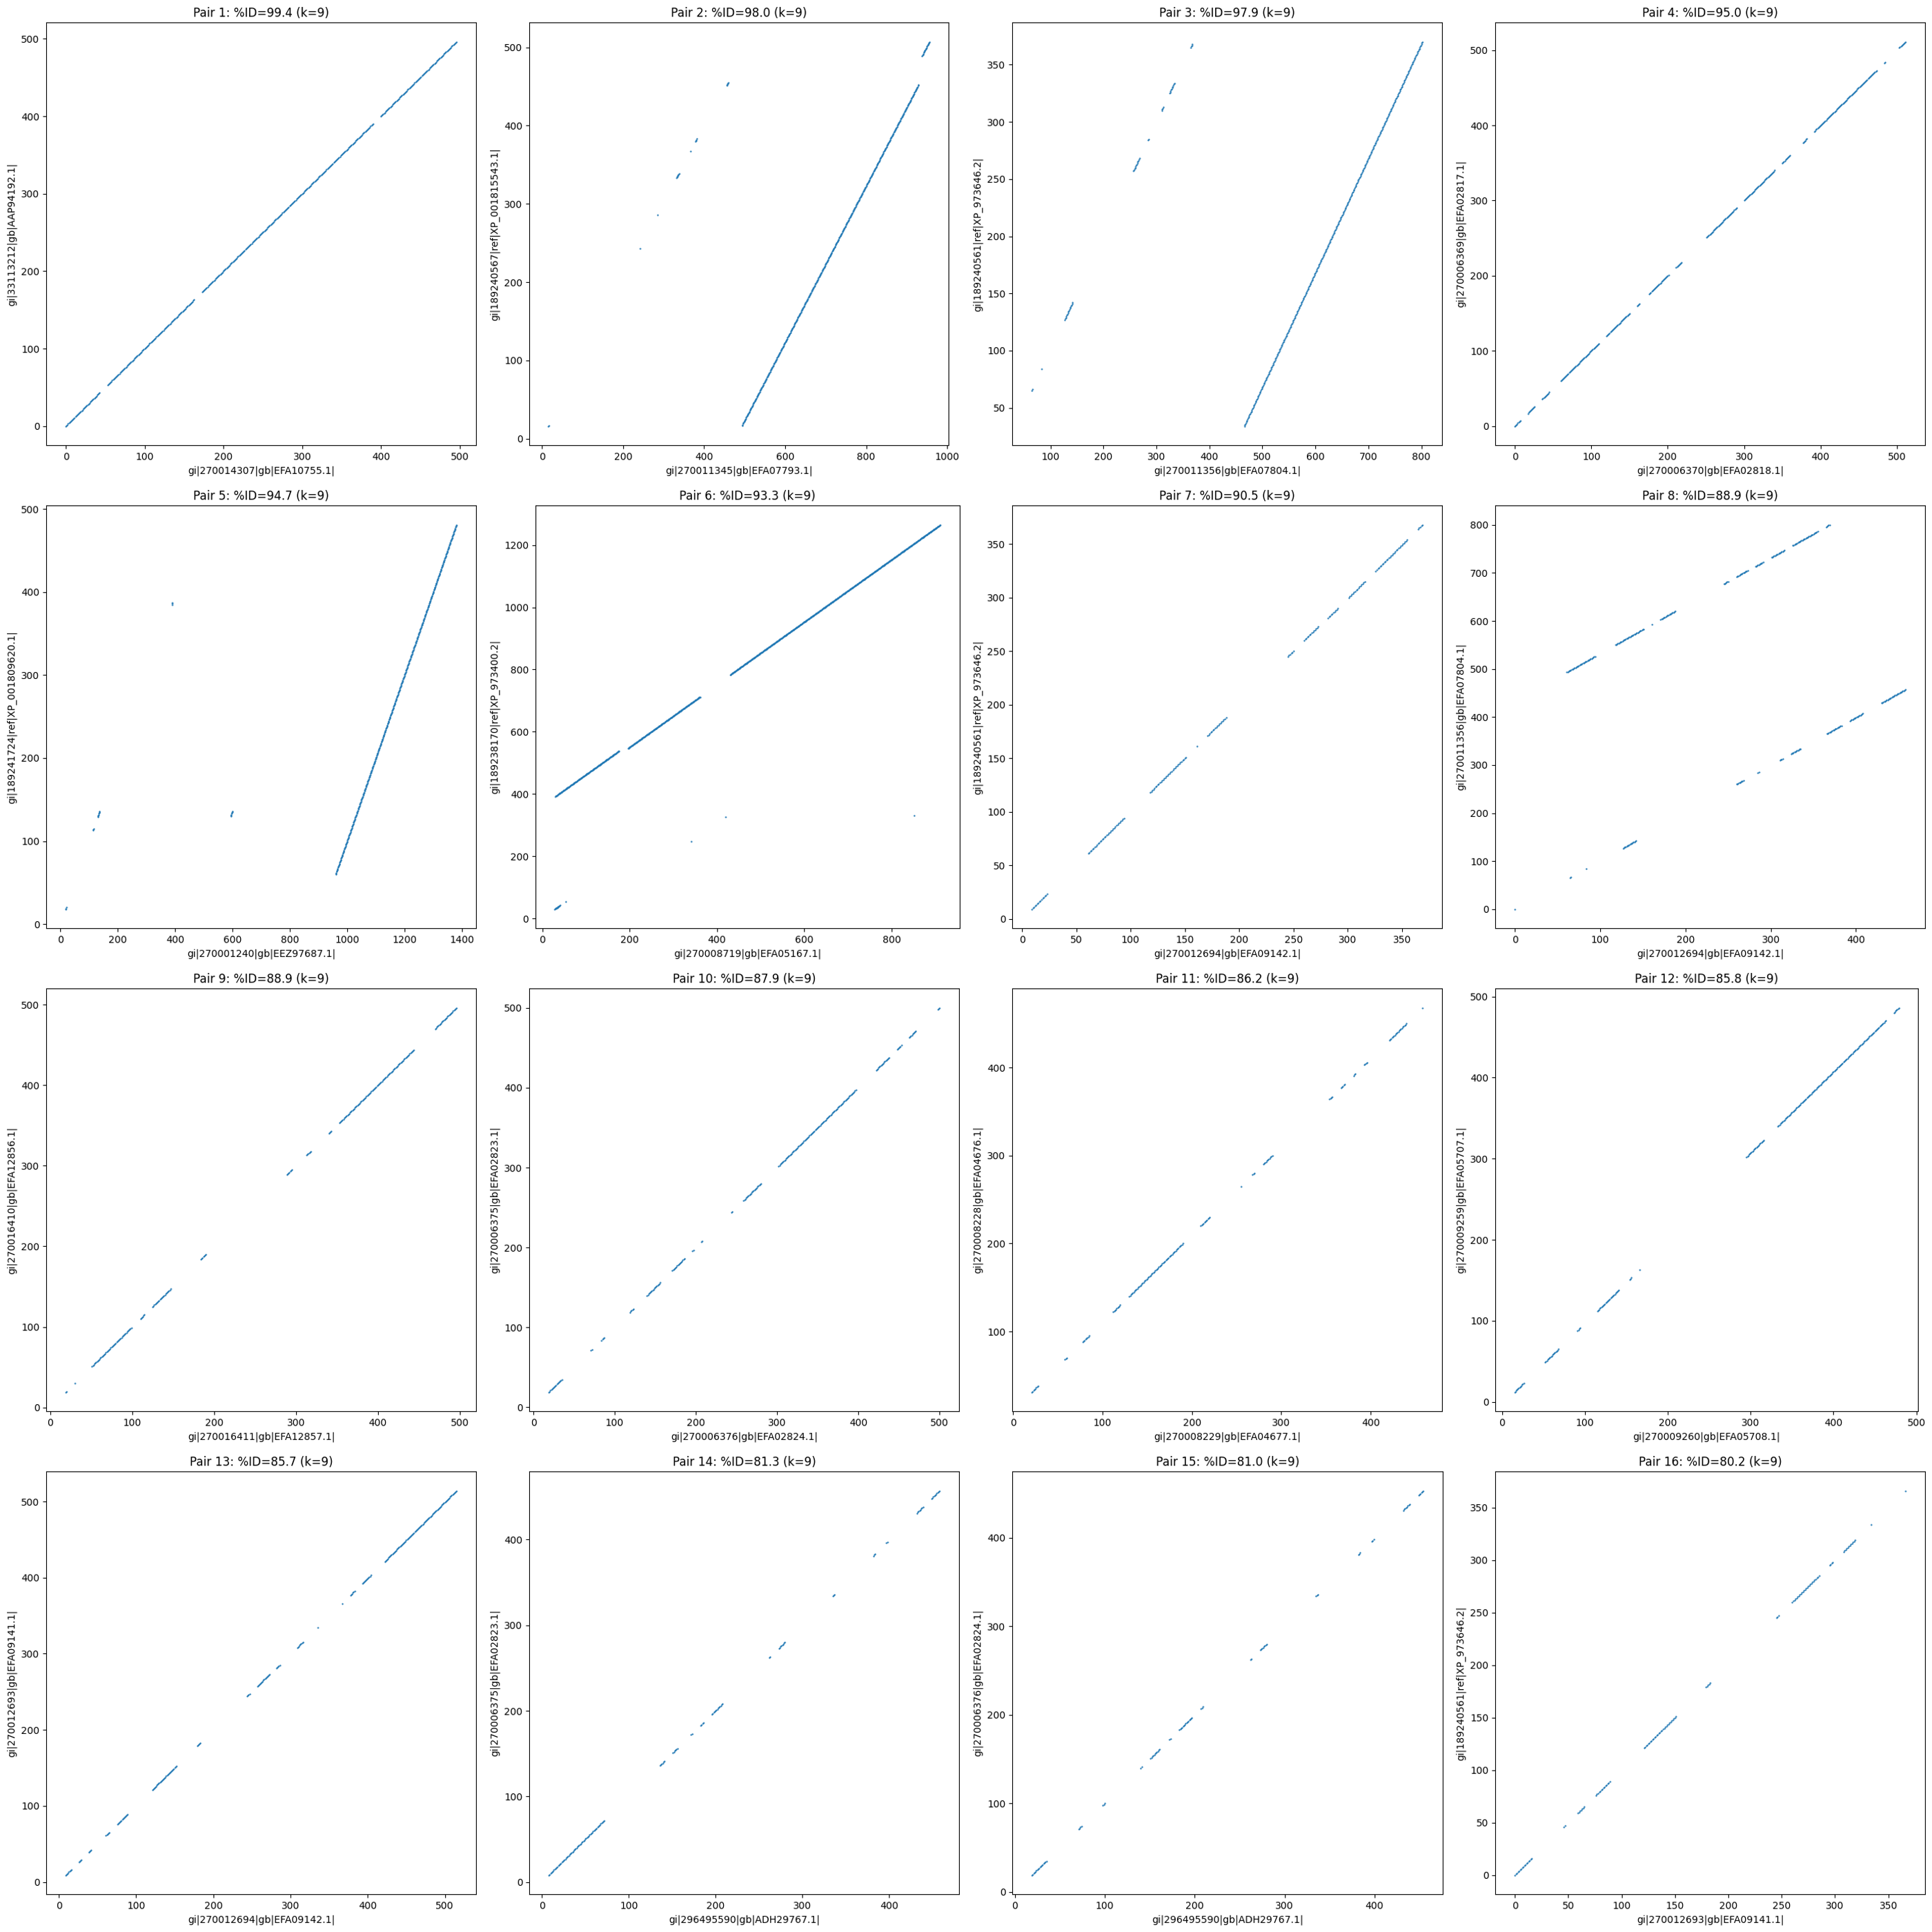

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
# Import tools
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from Bio import AlignIO
from PIL import Image
import os

msa_path = "P450_aln.fasta"   # alignment file already in /content/
msa_format = "fasta"

# ---------- params you can tweak ----------
k = 9                    # k-mer size for dot plots (larger -> cleaner diagonals)
tiles_per_row = 4
tiles_per_col = 4
tile_size_px = (700, 700)   # pixel size of each tile in the final grid
out_dir = "dotplot_tiles"
grid_out = "top16_dotplots_grid.png"
# ------------------------------------------

# Load alignment
aln = AlignIO.read(msa_path, msa_format)
N = len(aln)
ids = [rec.id for rec in aln]
seqs = [str(rec.seq) for rec in aln]
seq_bytes = [np.frombuffer(s.encode("ascii"), dtype="S1") for s in seqs]

# Pairwise identity ignoring gaps (and only comparing aligned positions)
pairs = []
for i in range(N):
    A = seq_bytes[i]
    for j in range(i+1, N):
        B = seq_bytes[j]
        valid = (A != b'-') & (B != b'-')
        denom = int(valid.sum())
        pid = float((A[valid] == B[valid]).sum())/denom if denom else 0.0
        pairs.append((pid, i, j))

# Top 16 pairs
pairs.sort(key=lambda x: x[0], reverse=True)
top_pairs = pairs[:tiles_per_row * tiles_per_col]

# Helper: dot-plot points from UNGAPPED sequences using k-mer matches
def dotplot_points(s1, s2, k):
    s1u = s1.replace('-', '')
    s2u = s2.replace('-', '')
    index = {}
    # index k-mers of s2
    L2 = len(s2u)
    for j in range(L2 - k + 1):
        km = s2u[j:j+k]
        index.setdefault(km, []).append(j)
    xs, ys = [], []
    L1 = len(s1u)
    for i in range(L1 - k + 1):
        km = s1u[i:i+k]
        js = index.get(km)
        if js:
            xs.extend(js)
            ys.extend([i]*len(js))
    return np.array(xs), np.array(ys), s1u, s2u

# Make individual tiles
os.makedirs(out_dir, exist_ok=True)
tile_paths = []
for idx, (pid, i, j) in enumerate(top_pairs, start=1):
    x, y, s1u, s2u = dotplot_points(seqs[i], seqs[j], k)
    fig = plt.figure(figsize=(tile_size_px[0]/100, tile_size_px[1]/100), dpi=100)
    plt.scatter(x, y, s=0.5)   # don't set explicit colors; keep default
    plt.xlabel(ids[j])
    plt.ylabel(ids[i])
    plt.title(f"Pair {idx}: %ID={pid*100:.1f} (k={k})")
    plt.tight_layout()
    out_path = os.path.join(out_dir, f"dotpair_{idx:02d}.png")
    plt.savefig(out_path, bbox_inches="tight")
    plt.close(fig)
    tile_paths.append(out_path)

# Stitch into a 4×4 grid
grid_w = tiles_per_row * tile_size_px[0]
grid_h = tiles_per_col * tile_size_px[1]
grid = Image.new("RGB", (grid_w, grid_h), (255, 255, 255))

for idx, path in enumerate(tile_paths):
    r = idx // tiles_per_row
    c = idx % tiles_per_row
    img = Image.open(path).resize(tile_size_px)
    grid.paste(img, (c*tile_size_px[0], r*tile_size_px[1]))

grid.save(grid_out)
print("Saved grid ->", grid_out)

#Display the graphs
from IPython.display import Image as IPyImage, display
display(IPyImage(filename=grid_out))
from google.colab import files
files.download(grid_out)

# Run TrimAl to automate trimming alignments
* https://trimal.cgenomics.org/


In [8]:
# run trimal, output the trimmed sequences and html to visualize conserved sites
# creates P450_trimmed.fasta - for input to new MSA
!trimal -in P450_aln.fasta -out P450_trimmed.fasta -htmlout trimmed.html -automated1

#Run MAFFT on trimmed sequences

In [9]:
# run mafft in auto mode
!mafft --auto P450_trimmed.fasta > P450_trimmed_aln.fasta

outputhat23=2
treein = 0
compacttree = 0
stacksize: 8192 kb
rescale = 1
All-to-all alignment.
tbfast-pair (aa) Version 7.490
alg=L, model=BLOSUM62, 2.00, -0.10, +0.10, noshift, amax=0.0
0 thread(s)

outputhat23=2
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
  120 / 129
done.

Progressive alignment ... 
STEP   128 /128 
done.
tbfast (aa) Version 7.490
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
1 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 0
randomseed = 0
blosum 62 / kimura 200
poffset = 0
niter = 2
sueff_global = 0.100000
nadd = 2
Loading 'hat3' ... done.
rescale = 1

  120 / 129
Segment   1/  1    1- 448
done
dvtditr (aa) Version 7.490
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 L-INS-i (Probably most accurate, very slow)
 Iterative refinement method (<2) with LOCAL pa

# Generate dotplots for new trimmed MSA

Saved grid -> top16_dotplots_trimmed_grid.png


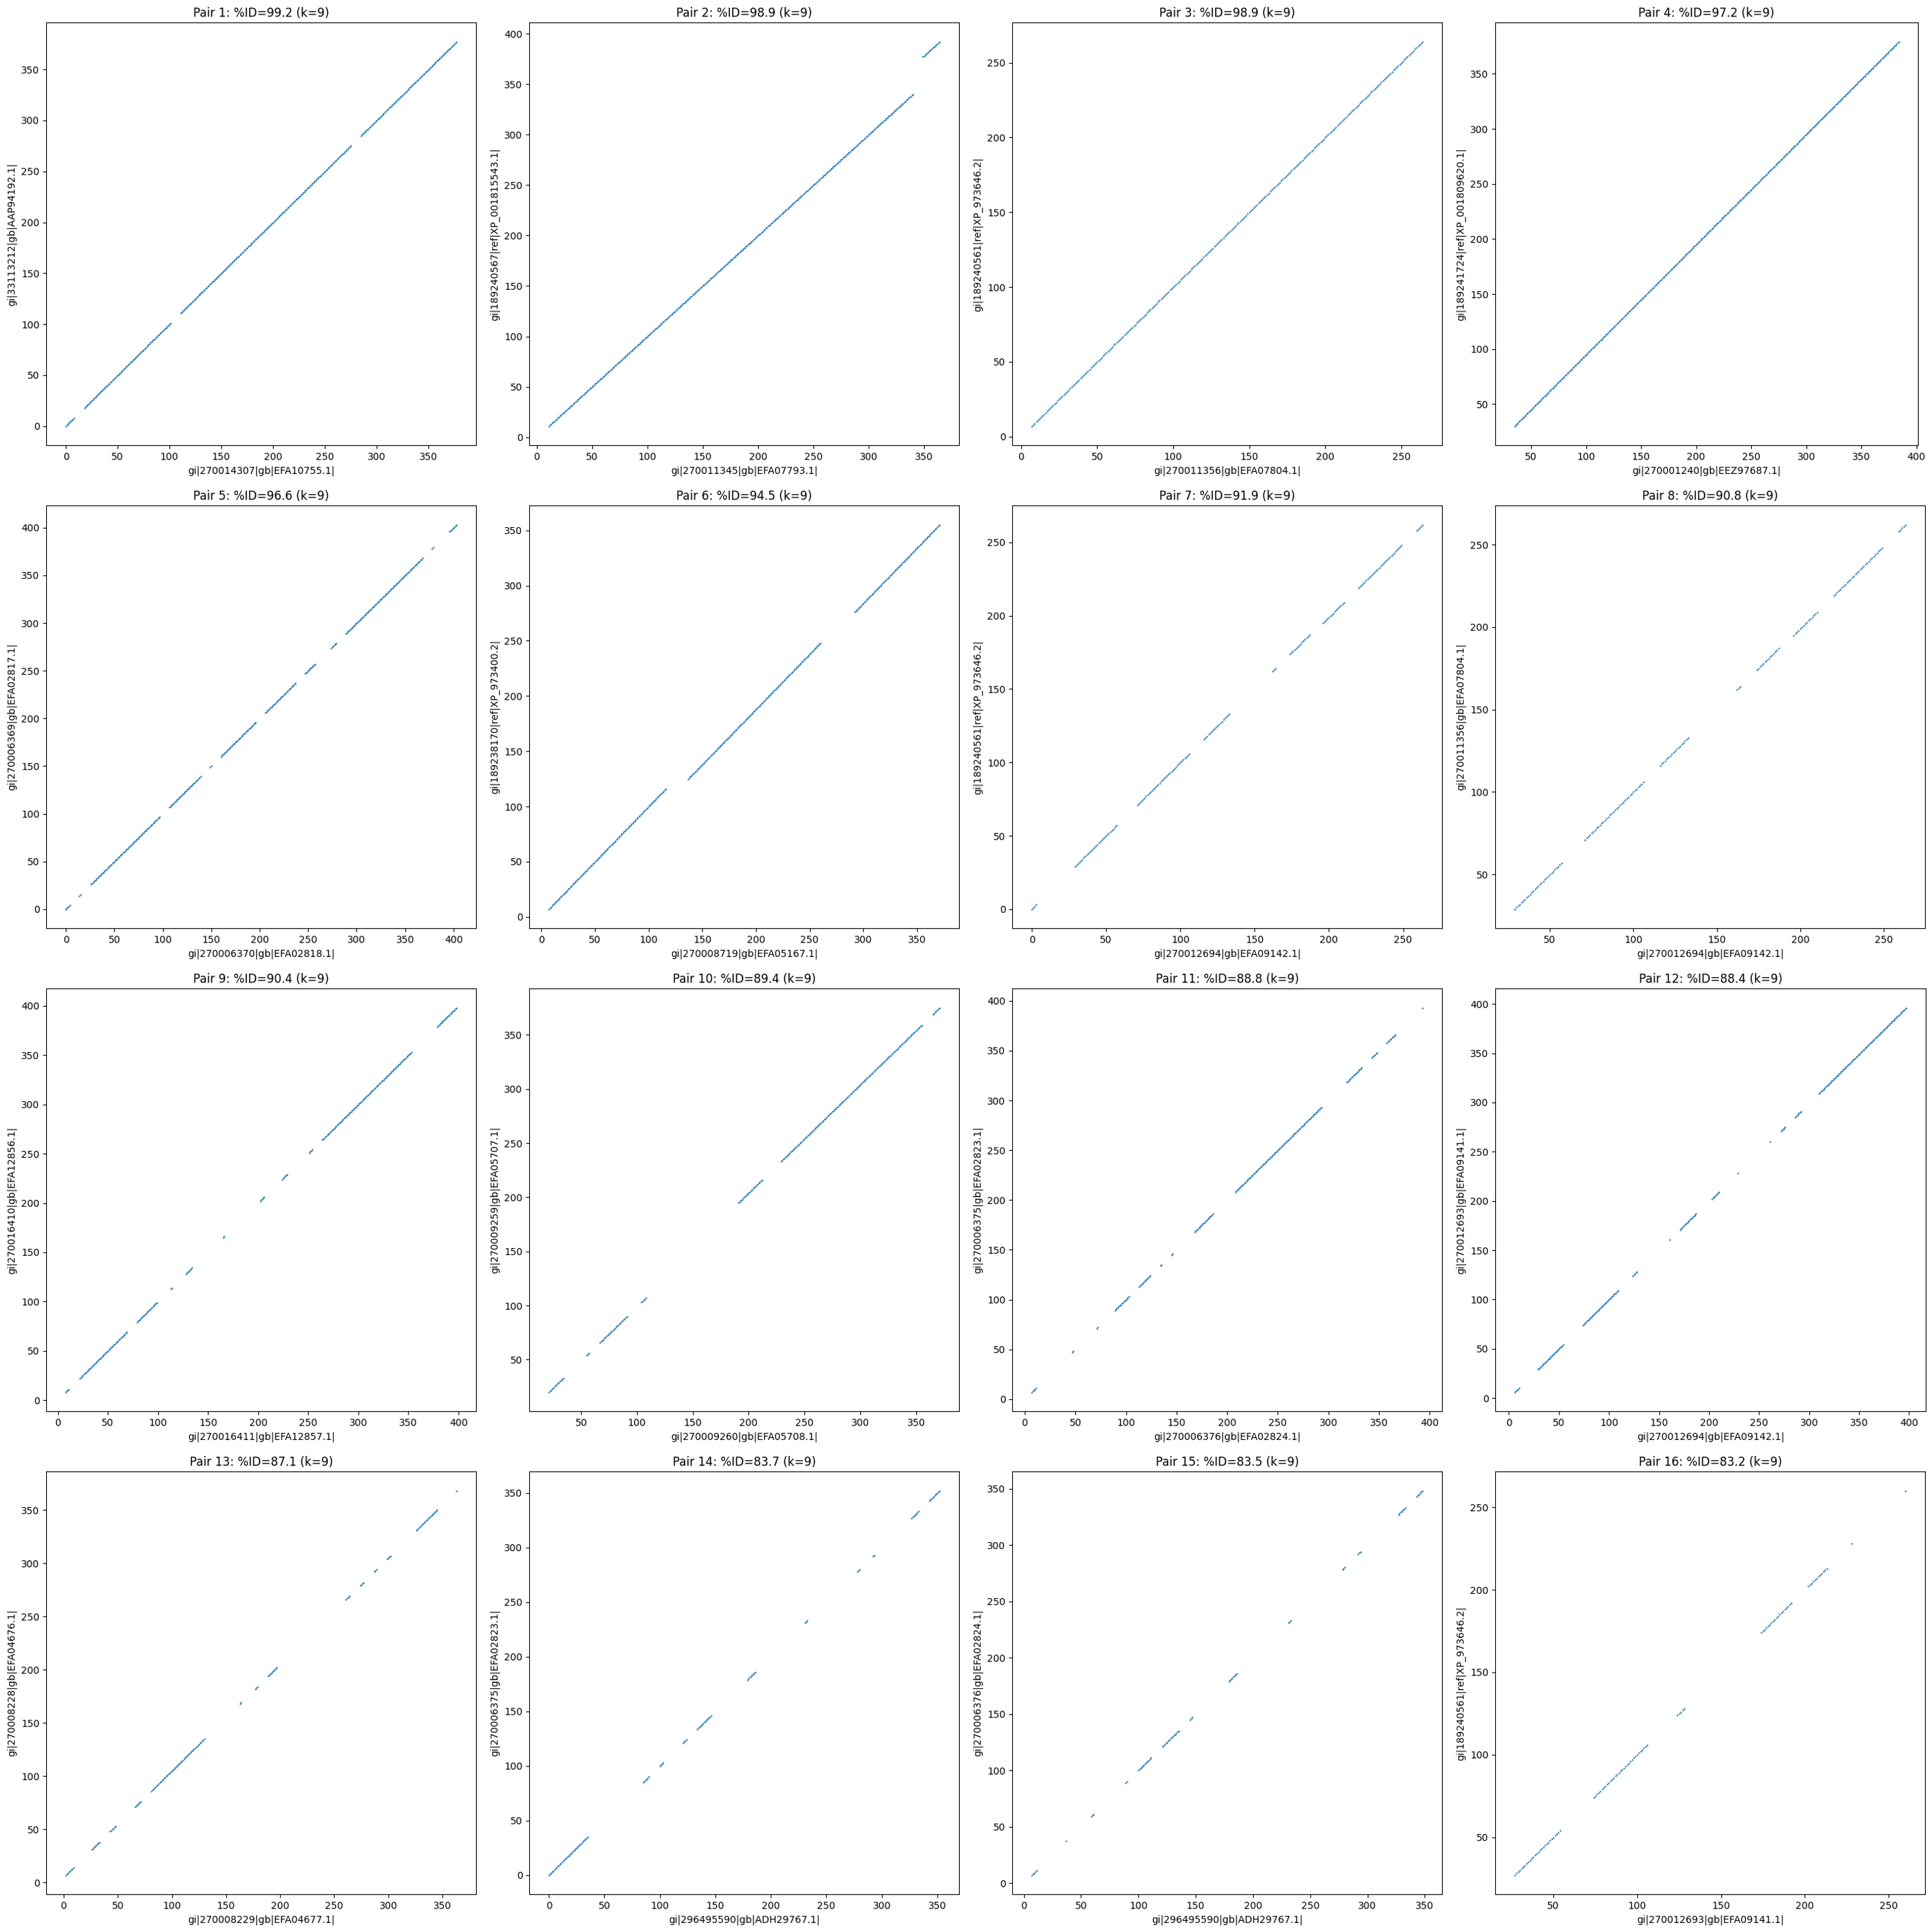

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
msa_path = "P450_trimmed_aln.fasta"   # trimmed alignment file already in /content/
msa_format = "fasta"

# ---------- params you can tweak ----------
k = 9                    # k-mer size for dot plots (larger -> cleaner diagonals)
tiles_per_row = 4
tiles_per_col = 4
tile_size_px = (700, 700)   # pixel size of each tile in the final grid
out_dir = "dotplot_tiles_trimmed"
grid_out = "top16_dotplots_trimmed_grid.png"
# ------------------------------------------

# Load alignment
aln = AlignIO.read(msa_path, msa_format)
N = len(aln)
ids = [rec.id for rec in aln]
seqs = [str(rec.seq) for rec in aln]
seq_bytes = [np.frombuffer(s.encode("ascii"), dtype="S1") for s in seqs]

# Pairwise identity ignoring gaps (and only comparing aligned positions)
pairs = []
for i in range(N):
    A = seq_bytes[i]
    for j in range(i+1, N):
        B = seq_bytes[j]
        valid = (A != b'-') & (B != b'-')
        denom = int(valid.sum())
        pid = float((A[valid] == B[valid]).sum())/denom if denom else 0.0
        pairs.append((pid, i, j))

# Top 16 pairs
pairs.sort(key=lambda x: x[0], reverse=True)
top_pairs = pairs[:tiles_per_row * tiles_per_col]

# Helper: dot-plot points from UNGAPPED sequences using k-mer matches
def dotplot_points(s1, s2, k):
    s1u = s1.replace('-', '')
    s2u = s2.replace('-', '')
    index = {}
    # index k-mers of s2
    L2 = len(s2u)
    for j in range(L2 - k + 1):
        km = s2u[j:j+k]
        index.setdefault(km, []).append(j)
    xs, ys = [], []
    L1 = len(s1u)
    for i in range(L1 - k + 1):
        km = s1u[i:i+k]
        js = index.get(km)
        if js:
            xs.extend(js)
            ys.extend([i]*len(js))
    return np.array(xs), np.array(ys), s1u, s2u

# Make individual tiles
os.makedirs(out_dir, exist_ok=True)
tile_paths = []
for idx, (pid, i, j) in enumerate(top_pairs, start=1):
    x, y, s1u, s2u = dotplot_points(seqs[i], seqs[j], k)
    fig = plt.figure(figsize=(tile_size_px[0]/100, tile_size_px[1]/100), dpi=100)
    plt.scatter(x, y, s=0.5)   # don't set explicit colors; keep default
    plt.xlabel(ids[j])
    plt.ylabel(ids[i])
    plt.title(f"Pair {idx}: %ID={pid*100:.1f} (k={k})")
    plt.tight_layout()
    out_path = os.path.join(out_dir, f"dotpair_{idx:02d}.png")
    plt.savefig(out_path, bbox_inches="tight")
    plt.close(fig)
    tile_paths.append(out_path)

# Stitch into a 4×4 grid
grid_w = tiles_per_row * tile_size_px[0]
grid_h = tiles_per_col * tile_size_px[1]
grid = Image.new("RGB", (grid_w, grid_h), (255, 255, 255))

for idx, path in enumerate(tile_paths):
    r = idx // tiles_per_row
    c = idx % tiles_per_row
    img = Image.open(path).resize(tile_size_px)
    grid.paste(img, (c*tile_size_px[0], r*tile_size_px[1]))

grid.save(grid_out)
print("Saved grid ->", grid_out)

#Display the graphs
from IPython.display import Image as IPyImage, display
display(IPyImage(filename=grid_out))
from google.colab import files
files.download(grid_out)

# Create a gene tree to show relationships among the sequences
* This code creates a circular layout tree, but that is an aesthetic choice

129 sequences; alignment length 440
Saved Newick -> gene_tree_nj.newick


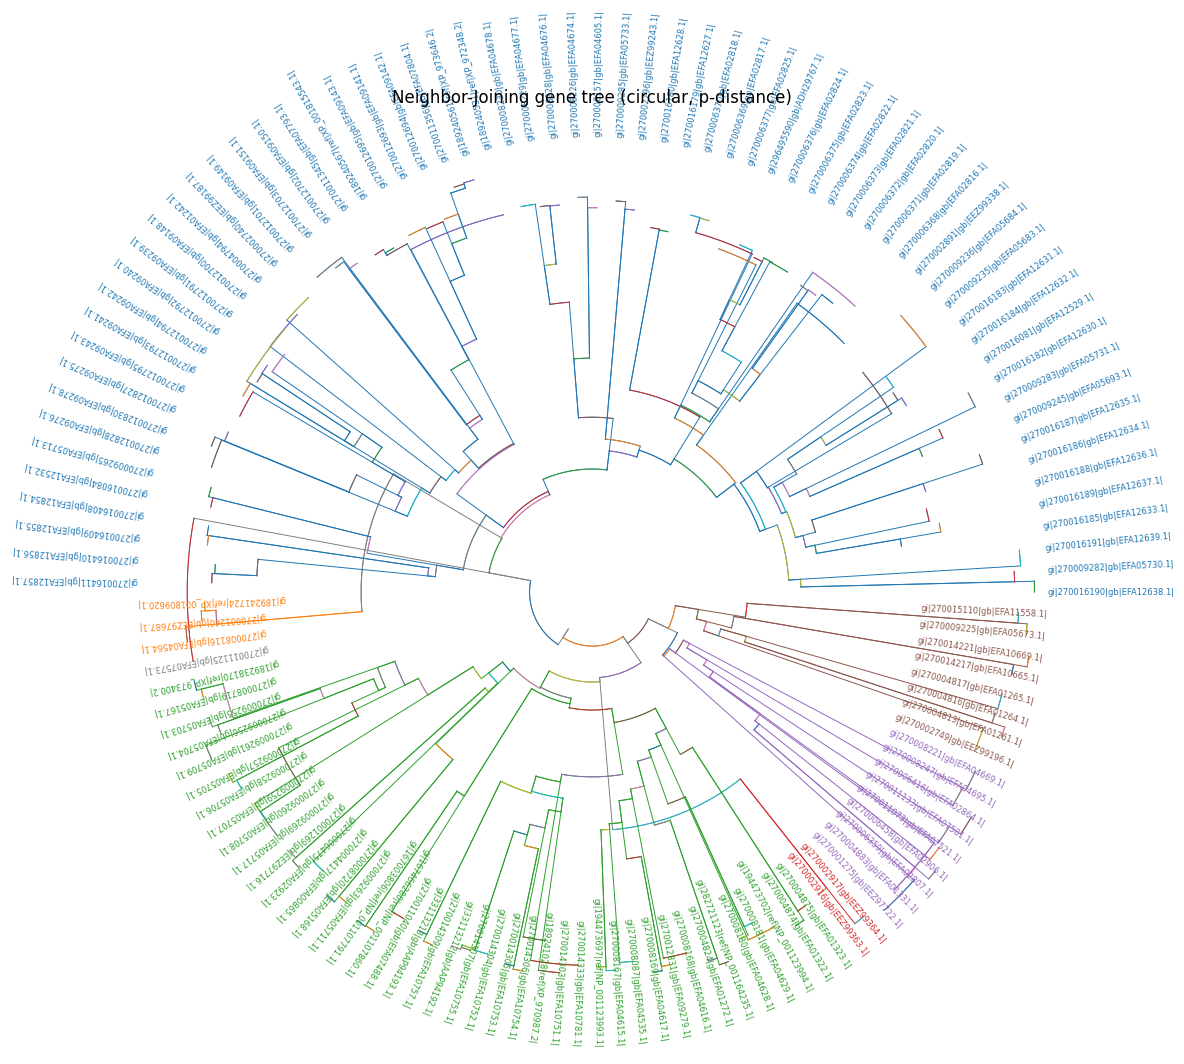

Saved PNG -> gene_tree_circular.png


In [11]:
import numpy as np
from Bio import AlignIO, Phylo
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceMatrix
import math
import matplotlib.pyplot as plt

# Load alignment
aln = AlignIO.read(msa_path, msa_format)
ids = [rec.id for rec in aln]
seqs = [np.frombuffer(str(rec.seq).encode("ascii"), dtype="S1") for rec in aln]
N = len(seqs)
print(f"{N} sequences; alignment length {aln.get_alignment_length()}")

# Fast p-distance: 1 - identity, comparing only positions where both are not gaps ('-')
def pairwise_pdist(A, B):
    valid = (A != b'-') & (B != b'-')
    denom = int(valid.sum())
    if denom == 0:
        return 1.0
    return 1.0 - float((A[valid] == B[valid]).sum()) / denom

# Build lower-triangular distance matrix
dm_mat = [[0.0]*(i+1) for i in range(N)]
for i in range(N):
    for j in range(i):
        dm_mat[i][j] = pairwise_pdist(seqs[i], seqs[j])

dm = DistanceMatrix(names=ids, matrix=dm_mat)

# Neighbor-Joining tree
constructor = DistanceTreeConstructor()
tree = constructor.nj(dm)

# Midpoint root for symmetry
try:
    tree.root_at_midpoint()
except Exception:
    pass

# Save Newick
newick_path = "gene_tree_nj.newick"
Phylo.write(tree, newick_path, "newick")
print("Saved Newick ->", newick_path)

# Compute clade depths (distance from root)
def clade_depths(clade, current=0.0, depths=None):
    if depths is None:
        depths = {}
    depths[clade] = current
    for child in clade.clades:
        bl = child.branch_length or 0.0
        clade_depths(child, current + bl, depths)
    return depths

depths = clade_depths(tree.root)
max_depth = max(depths.values()) or 1.0
def radius_of(clade):
    # map to [0.1, 1.0] for margin
    return 0.1 + 0.9 * (depths[clade] / max_depth)

# Evenly spaced leaf angles
terms = tree.get_terminals()
n_leaves = len(terms)
leaf_to_angle = {t: 2*math.pi * i / n_leaves for i, t in enumerate(terms)}

# Angle of internal nodes = circular mean of child angles
def compute_angles(clade):
    if clade.is_terminal():
        return leaf_to_angle[clade]
    child_angles = [compute_angles(c) for c in clade.clades]
    x = sum(math.cos(a) for a in child_angles) / len(child_angles)
    y = sum(math.sin(a) for a in child_angles) / len(child_angles)
    return math.atan2(y, x) % (2*math.pi)

angles = {}
def assign_angles(clade):
    angles[clade] = compute_angles(clade)
    for c in clade.clades:
        assign_angles(c)
assign_angles(tree.root)

# Draw on polar axes (one chart, no explicit colors)
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection="polar")
ax.set_axis_off()
# ----- choose which "level" to color by -----
L = 3  # e.g., root=0, children=1, etc.

# Compute topological levels (edge-count from root)
def clade_levels(clade, level=0, out=None):
    if out is None: out = {}
    out[clade] = level
    for ch in clade.clades:
        clade_levels(ch, level+1, out)
    return out

levels = clade_levels(tree.root)

# Anchor nodes at level L
anchors = [c for c, lv in levels.items() if lv == L]

# Assign colors and paint entire subtrees below each anchor
cmap = plt.get_cmap("tab10")
edge_colors = {}                         # (parent, child) -> color
anchor_color = {}                        # node at level L -> color

def paint_subtree(node, color):
    for ch in node.clades:
        edge_colors[(node, ch)] = color
        paint_subtree(ch, color)

for i, a in enumerate(anchors):
    col = cmap(i % 10)
    anchor_color[a] = col
    paint_subtree(a, col)

# (optional) make leaves’ label text match their subtree color
anchor_set = set(anchors)
def color_of_leaf(leaf):
    # path from root to leaf; first anchor we encounter decides color
    path = [tree.root] + tree.get_path(leaf)
    for n in path:
        if n in anchor_set:
            return anchor_color[n]
    return "0.5"


def draw_branch(parent, child):
    rp, rc = radius_of(parent), radius_of(child)
    ap, ac = angles[parent], angles[child]
    da = (ac - ap + math.pi) % (2*math.pi) - math.pi
    th = np.linspace(ap, ap + da, 24)

    col = edge_colors.get((parent, child), "0.5")
    ax.plot([ap, ap], [rp, rc], linewidth=0.7, color=col)
    ax.plot(th, np.full_like(th, rc), linewidth=0.7, color=col)

    # shortest arc to child angle at child radius
    da = (ac - ap + math.pi) % (2*math.pi) - math.pi
    th = np.linspace(ap, ap + da, 24)
    ax.plot(th, np.full_like(th, rc), linewidth=0.7)

for parent in tree.find_clades(order="level"):
    for child in parent.clades:
        draw_branch(parent, child)

# Leaf labels
label_r = 1.03
for t in terms:
    a = angles[t]
    ax.text(a, label_r, t.name, fontsize=6,
            rotation=np.degrees(a), rotation_mode="anchor",
            ha="left" if 0 <= a <= math.pi else "right",
            va="center",
            color=color_of_leaf(t))

plt.title("Neighbor-Joining gene tree (circular, p-distance)", pad=20)
png_path = "gene_tree_circular.png"
plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved PNG ->", png_path)